In [22]:
import os
from tabulate import tabulate
from nilearn import plotting
from nilearn import image
from nilearn.image import math_img, resample_to_img, get_data
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.plotting import plot_stat_map, view_img
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Fetch the Harvard-Oxford atlas
ATLAS = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
# Load the atlas image
ATLAS_IMAGE = image.load_img(ATLAS.maps)
ATLAS_DATA = get_data(ATLAS_IMAGE)
# Extract region names from the atlas
LABEL_NAMES = ATLAS['labels']
# Extract unique region labels from the atlas
REGION_LABELS = np.unique(ATLAS_DATA)

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


In [3]:
def get_subject_file_pairs(data_dir, subjectDF):
    file_pairs = []
    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)

        # Skip non-directories or irrelevant files
        if not os.path.isdir(subject_path) or subject.startswith('.') or subject == 'derivatives':
            continue

        for index, row in subjectDF.iterrows():
            subject = row['participant_id']
            subject_path = os.path.join(data_dir, f"sub-{subject:03d}")

            # Locate BL and FU files
            baseline_file = os.path.join(subject_path, 'ses-BL', 'anat', f"sub-{subject:03d}_ses-BL_T1w.nii.gz")
            followup_file = os.path.join(subject_path, 'ses-FU', 'anat', f"sub-{subject:03d}_ses-FU_T1w.nii.gz")

            # Verify that both files exist
            if os.path.exists(baseline_file) and os.path.exists(followup_file):
                # Add the file paths to the DataFrame
                subjectDF.at[index, 'Baseline File Path'] = 'Data/' + os.path.relpath(baseline_file, data_dir)
                subjectDF.at[index, 'Followup File Path'] = 'Data/' + os.path.relpath(followup_file, data_dir)
            else:
                print(f"Skipping subject {subject}: missing files.")

In [4]:
def loadImage(imgPath):
    img = image.load_img(imgPath)
    img = resample_to_img(source_img=img, target_img=ATLAS_IMAGE, force_resample=True, copy_header=True)
    img = image.smooth_img(img, fwhm=6)
    return img

def findDifferingAreas(index, regionList, img1, img2):
    # Creates the difference map
    diff = image.math_img("img1 - img2", img1=img1, img2=img2)
    diff_data = get_data(diff)
    # Loop through each region to compute statistics
    for label in REGION_LABELS:
        regionMask = (ATLAS_DATA == label)
        regionChanges = diff_data[regionMask]
        region_mean = round(float(np.mean(regionChanges)), 2)
        if 0 <= label < len(LABEL_NAMES):
            region_name = LABEL_NAMES[label]  # Adjust for 1-based indexing
        else:
            region_name = "Unknown Region"
        # Insert the region_mean into the correct column and row in the DataFrame
        participants_df.loc[index, f"{region_name} Change"] = region_mean

In [5]:
participants_df = pd.read_csv('Data/participants.tsv', sep="\t")
# Add columns for file paths
filePaths = ['Baseline File Path', 'Followup File Path']
for label in filePaths:
    participants_df[label] = None
get_subject_file_pairs('Data', participants_df)
for label in LABEL_NAMES:
    participants_df[label + ' Change'] = None

In [6]:
for index, row in participants_df.iterrows():
    baseLinePath = participants_df.loc[index,'Baseline File Path']
    followUpPath = participants_df.loc[index,'Followup File Path']
    baseLine = loadImage(baseLinePath)
    followUp = loadImage(followUpPath)
    findDifferingAreas(index, participants_df, baseLine, followUp)
    
participants_df = participants_df.drop(columns=['Baseline File Path', 'Followup File Path'])

In [10]:
import subprocess
output_excel_path = 'participants_with_changes_test.xlsx'
participants_df.to_excel(output_excel_path, index=False)
subprocess.run(["open", output_excel_path])

CompletedProcess(args=['open', 'participants_with_changes_test.xlsx'], returncode=0)

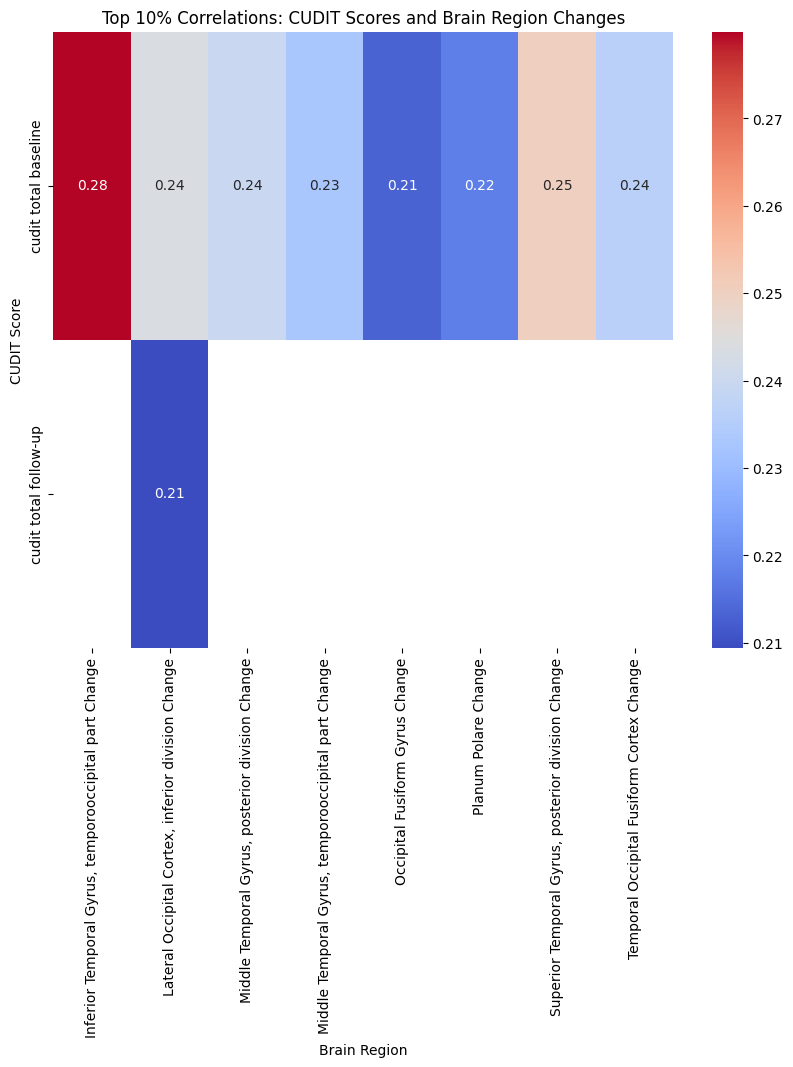

In [28]:
cudit_columns = ['cudit total baseline', 'cudit total follow-up']
brain_region_columns = [col for col in participants_df.columns if 'Change' in col]
# Combine into one dataset
correlation_data = participants_df[cudit_columns + brain_region_columns]

# Compute correlations
correlation_matrix = correlation_data.corr()
cudit_correlations = correlation_matrix.loc[cudit_columns, brain_region_columns]

# Step 1: Flatten the correlation matrix into a long format
correlation_values = cudit_correlations.stack().reset_index()
correlation_values.columns = ['CUDIT Score', 'Brain Region', 'Correlation']

# Step 2: Add absolute correlation values for sorting
correlation_values['Abs Correlation'] = correlation_values['Correlation'].abs()

# Step 3: Filter for the top 10% of correlations
top_10_percent = correlation_values.sort_values(by='Abs Correlation', ascending=False)
threshold_index = int(len(top_10_percent) * 0.1)
top_10_percent = top_10_percent.iloc[:threshold_index]

# Step 4: Pivot the filtered data back to a matrix format for heatmap
filtered_correlation_matrix = top_10_percent.pivot(index='CUDIT Score', columns='Brain Region', values='Correlation')

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Top 10% Correlations: CUDIT Scores and Brain Region Changes")
plt.show()